Аналитическая задача -- составить портрет клиента, склонного откликнуться на предложение о новой карте.

## Описание данных

|Комментарий| Признак|
|--:|:--|
|Ипотечный кредит | mortgage|
|Страхование жизни | life_ins|
|Кредитная карта | cre_card|
|Дебетовая карта | deb_card|
|Мобильный банк | mob_bank|
|Текущий счет | curr_acc|
|Интернет-доступ к счету | internet|
|Индивидуальный заем | perloan|
|Наличие сбережений | savings|
|Пользование банкоматом за последнюю неделю | atm_user|
|Пользование услугами онлайн-маркетплейса за последний месяц | markpl|
|Возраст | age |
|Давность клиентской истории | cus_leng |
|Отклик на предложение новой карты | response |

Примечание: 1 -- наличие продукта/услуги/отклика; 0 -- отсутствие продукта/услуги/отклика.  

**Примерный план исследования**

Шаг 1. Загрузка данных;

Шаг 2. Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения;

Шаг 3. Исследовательский анализ данных
- в разрезе значений целевого признака (`response` -- Отклик на предложение новой карты	) исследовать распределения признаков;
- исследовать возможные зависимости целевого признака от объясняющих признаков;
- в разрезе целевого признака составить портреты клиентов платежной системы;

Шаг 4. Составить и проверить гипотезы о наличие/отсутствии различий по признакам портрета клиента.

Шаг 5. Построить классификационные модели (дополнительное задание).


## Библиотеки

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import shap
import xgboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import optuna

# Блок функций проекта

In [ ]:
# Расчет квантилей
def calculate_iqr_boundaries(series):
  q25 = series.quantile(0.25)
  q75 = series.quantile(0.75)
  iqr = q75 - q25

  boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
  return boundaries



# Кодирование категориальных признаков трейн и тест (тест на обученном препроцессоре)
def encode_category_feature(X, df_predict, category_feature_list):
    encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    # Применение OneHotEncoder
    encoded_train = encoder.fit_transform(X[category_feature_list])
    # кодируем предикт
    encoded_predict = encoder.transform(df_predict[category_feature_list])
    # Преобразование результата обратно в DataFrame
    encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(category_feature_list))
    encoded_predict_df = pd.DataFrame(encoded_predict, columns=encoder.get_feature_names_out(category_feature_list))
    # Сброс индексов
    X.reset_index(drop=True, inplace=True)
    df_predict.reset_index(drop=True, inplace=True)

    encoded_train_df.reset_index(drop=True, inplace=True)
    encoded_predict_df.reset_index(drop=True, inplace=True)
    # Объединение с сбросом индексов
    X_encoded = pd.concat([X, encoded_train_df], axis=1)
    predict_encoded = pd.concat([df_predict, encoded_predict_df], axis=1)
    # Удаление оригинального столбца
    X_encoded = X_encoded.drop(columns=category_feature_list)
    predict_encoded = predict_encoded.drop(columns=category_feature_list)

    return X_encoded, predict_encoded



# нормализация непрерывных признаков
def standard(X, df_predict, numeric):
    # Применяем StandardScaler к X, numeric
    st_scaler = StandardScaler()
    X[numeric] = st_scaler.fit_transform(X[numeric])
    # Применяем StandardScaler к predict
    df_predict[numeric] = st_scaler.transform(df_predict[numeric])

    return X, df_predict



def scaler(X, df_predict, numeric):
    mm_scaler = MinMaxScaler()
    # Применение MinMaxScaler к признакам
    df[numeric] = mm_scaler.fit_transform(X[numeric])
    # Применяем к predict
    df_predict[numeric] = mm_scaler.transform(df_predict[numeric])

    return X, df_predict




# Удаление признаков с низкой корреляцией
def high_corr(df):
    # сразу удалим id
    df.drop(['id'], axis=1, inplace=True, errors='ignore')
    min_corr = []
    for i in df.columns:
        j = df[i]
        corr = df['response'].corr(j)
        #print(i, corr)
        if -0.01 < corr and corr < 0.01:
            min_corr.append(i)

    print(min_corr)
    df.drop(min_corr, axis=1, inplace=True)

    return df



# Удаление признаков с нулевой значимостью
def important(df):
    # Определение данных
    X = df.drop(['response'], axis=1)
    y = df['response']
    # Обучение модели
    params = {
        'objective': 'binary:logistic',
        'max_depth': 3,
        'learning_rate': 0.1
        }
    model = xgboost.train(params, xgboost.DMatrix(X, y), num_boost_round=10)
    # Создание объекта Explainer и получение SHAP значений
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    # Преобразуем shap_values в DataFrame для удобной работы
    shap_df = pd.DataFrame(shap_values, columns=X.columns)
    # Создание переменной no_good для признаков с нулевой значимостью
    no_good = shap_df.mean().index[shap_df.mean() == 0].tolist()
    # Выводим список признаков с нулевой значимостью
    print("Признаки с нулевой значимостью:")
    print(no_good)

    df.drop(no_good, axis=1, inplace=True)

    return df



# моделирование для тестовых моделей
def modeling(model_name, X_train_encoded, y_train, X_test_encoded, y_test):
    # Инициализация модели
    model = model_name

    # Обучение модели
    model.fit(X_train_encoded, y_train)

    # Получим предсказания и вероятности
    y_train_pred = model.predict(X_train_encoded)
    y_test_pred = model.predict(X_test_encoded)

    y_train_proba = model.predict_proba(X_train_encoded)
    y_test_proba = model.predict_proba(X_test_encoded)

    # Расчёт метрик ROC AUC
    roc_auc_train = roc_auc_score(y_train, y_train_proba[:, 1])  # Метрика для обучающей выборки
    roc_auc_test = roc_auc_score(y_test, y_test_proba[:, 1])      # Метрика для тестовой выборки

    # Расчёт кросс-валидации для ROC AUC
    roc_auc_cv = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring='roc_auc').mean()

    # Расчёт других метрик
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)

    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)

    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)

    # Расчёт кросс-валидации для F1
    f1_cv = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring='f1').mean()

    # Вычисление матрицы ошибок
    cm = confusion_matrix(y_test, y_test_pred)

    # Значения из матрицы ошибок
    tn, fp, fn, tp = cm.ravel()

    # Создадим сводную таблицу для результатов
    df_result = pd.DataFrame({
        'model_name': [model_name.__class__.__name__],  # Название модели
        'roc_auc_train': [roc_auc_train],                # ROC AUC для обучающей выборки
        'roc_auc_test': [roc_auc_test],                  # ROC AUC для тестовой выборки
        'roc_auc_cv': [roc_auc_cv],                      # ROC AUC кросс-валидации
        'accuracy_train': [accuracy_train],              # Accuracy для обучающей выборки
        'accuracy_test': [accuracy_test],                # Accuracy для тестовой выборки
        'recall_train': [recall_train],                  # Recall для обучающей выборки
        'recall_test': [recall_test],                    # Recall для тестовой выборки
        'f1_train': [f1_train],                          # F1 для обучающей выборки
        'f1_test': [f1_test],                            # F1 для тестовой выборки
        'f1_cv': [f1_cv],                                # F1 кросс-валидации
        'tn': [tn],                                      # True Negatives
        'fp': [fp],                                      # False Positives
        'fn': [fn],                                      # False Negatives
        'tp': [tp]                                       # True Positives
    })

    return df_result




# Моделирование с выбором лучшей модели и подбором гиперпараметров
def objective(trial):
    # Выбор классификатора
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'LGBM', 'CatBoost', 'XGBoost'])
    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

    elif classifier_name == 'LGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)
        clf = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate)

    elif classifier_name == 'CatBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)
        depth = trial.suggest_int('depth', 1, 16)
        clf = CatBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, depth=depth, verbose=0)

    else:  # XGBoost
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        clf = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, use_label_encoder=False, eval_metric='logloss')

    # Кросс-валидация
    scores = cross_val_score(clf, X_train_norm_l, y_train_l, cv=5, scoring='roc_auc')  # 5-кратная кросс-валидация

    return scores.mean()  # Возвращаем средний roc_auc

# 1. Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Аналитик Данных/Итоговая работа/project_7/vrk_response_bank.csv', sep=';')
#df = pd.read_csv('vrk_response_bank.csv', sep=';')
df.shape

(30259, 14)

In [ ]:
df.head(5)

,mortgage,life_ins,cre_card,deb_card,mob_bank,curr_acc,internet,perloan,savings,atm_user,markpl,age,cus_leng,response
0,0,0,0,0,0,0,0,0,0,0,0,18,1,0
1,1,1,0,1,1,0,0,0,0,1,0,18,2,1
2,1,1,0,1,0,0,0,0,0,0,1,18,2,1
3,1,1,1,1,0,1,0,0,0,1,1,18,2,1
4,1,1,0,1,0,0,0,1,0,1,0,18,2,0


In [ ]:
# Сразу посмотрим значения целевой переменной
df['response'].value_counts()

,count
response,
0,17170
1,13089


# 2. Первичная обработка данных

## Коррекция заголовков

In [ ]:
# приводим заголовки к нижнему регистру
df.columns = df.columns.str.lower()

In [ ]:
# переименуем признаки

df = df.rename(columns={
        'mortgage':'Ипотечный_кредит' ,
        'life_ins':'Страхование_жизни',
        'cre_card':'Кредитная_карта',
        'deb_card':'Дебетовая_карта',
        'mob_bank':'Мобильный_банк',
        'curr_acc':'Текущий_счет',
        'internet':'Интернет_доступ',
        'perloan':'Индивидуальный_заем',
        'savings':'Наличие_сбережений',
        'atm_user':'Пользование_банкоматом_последнюю_неделю',
        'markpl':'Пользование_маркетплейса_последний_месяц',
        'age':'Возраст',
        'cus_leng':'Давность_клиентской_истории'
        #'response':'отклик'
        })

In [ ]:
# приводим заголовки к нижнему регистру
df.columns = df.columns.str.lower()

In [ ]:
df.columns

Index(['ипотечный_кредит', 'страхование_жизни', 'кредитная_карта',
       'дебетовая_карта', 'мобильный_банк', 'текущий_счет', 'интернет_доступ',
       'индивидуальный_заем', 'наличие_сбережений',
       'пользование_банкоматом_последнюю_неделю',
       'пользование_маркетплейса_последний_месяц', 'возраст',
       'давность_клиентской_истории', 'response'],
      dtype='object')

## Типы признаков

In [ ]:
df.dtypes

,0
ипотечный_кредит,int64
страхование_жизни,int64
кредитная_карта,int64
дебетовая_карта,int64
мобильный_банк,int64
текущий_счет,int64
интернет_доступ,int64
индивидуальный_заем,int64
наличие_сбережений,int64
пользование_банкоматом_последнюю_неделю,int64


In [ ]:
# просмотр количества значений в признаках
for i in df.columns:
    print(df[i].value_counts())

ипотечный_кредит
1    22425
0     7834
Name: count, dtype: int64
страхование_жизни
1    27396
0     2863
Name: count, dtype: int64
кредитная_карта
1    20575
0     9684
Name: count, dtype: int64
дебетовая_карта
1    18711
0    11548
Name: count, dtype: int64
мобильный_банк
0    26565
1     3694
Name: count, dtype: int64
текущий_счет
1    24403
0     5856
Name: count, dtype: int64
интернет_доступ
0    23890
1     6369
Name: count, dtype: int64
индивидуальный_заем
0    25825
1     4434
Name: count, dtype: int64
наличие_сбережений
0    21527
1     8732
Name: count, dtype: int64
пользование_банкоматом_последнюю_неделю
1    18345
0    11914
Name: count, dtype: int64
пользование_маркетплейса_последний_месяц
1    20811
0     9448
Name: count, dtype: int64
возраст
45    884
28    884
30    882
41    872
34    862
33    861
52    860
51    859
48    859
50    852
32    848
39    846
35    841
31    841
36    840
46    837
49    831
43    830
42    830
40    830
54    819
44    812
47    810
29 

In [ ]:
# Учитывая что все признаки числовые произведем условное разделение признаков по количеству значений в признаке
df_types = df.drop(['response'], axis=1)
numerical = [col for col in df_types.columns if len(df_types[col].value_counts()) > 5]
categorical = [col for col in df_types.columns if len(df_types[col].value_counts()) <= 5]
print(numerical)
print(categorical)

['возраст']
['ипотечный_кредит', 'страхование_жизни', 'кредитная_карта', 'дебетовая_карта', 'мобильный_банк', 'текущий_счет', 'интернет_доступ', 'индивидуальный_заем', 'наличие_сбережений', 'пользование_банкоматом_последнюю_неделю', 'пользование_маркетплейса_последний_месяц', 'давность_клиентской_истории']


## Проверка и обработка дубликатов

In [ ]:
# Выводим количество дубликатов в DataFrame df
duplicate_count = df.duplicated().sum()
print('Количество дубликатов в df:', duplicate_count)

Количество дубликатов в df: 16223


In [ ]:
# Выводим дублирующиеся строки
duplicates = df[df.duplicated()]
print('Дублирующиеся строки:\n', duplicates)

Дублирующиеся строки:
        ипотечный_кредит  страхование_жизни  кредитная_карта  дебетовая_карта  \
10                    1                  1                0                1   
19                    1                  1                0                1   
25                    1                  1                0                0   
29                    1                  1                0                1   
31                    1                  1                0                1   
...                 ...                ...              ...              ...   
30252                 1                  1                1                1   
30254                 1                  1                1                1   
30256                 1                  1                1                1   
30257                 1                  1                1                0   
30258                 1                  1                1                0   

       мобильный

In [ ]:
# Удалим дубликаты, просмотрим изменения целевой переменной
print('до удаления дублей', df.shape)
print(df['response'].value_counts())
df.drop_duplicates(inplace=True)
print('после удаления дублей', df.shape)
print(df['response'].value_counts())

до удаления дублей (30259, 14)
response
0    17170
1    13089
Name: count, dtype: int64
после удаления дублей (14036, 14)
response
1    7953
0    6083
Name: count, dtype: int64


## Проверка и обработка аномалий

In [ ]:
# Просмотр выбросов

for i in numerical:
    bounds = calculate_iqr_boundaries(df[i])
    out_l = sum(df[i] < bounds[0])
    out_r = sum(df[i] > bounds[1])
    print('-------', i, '-------')
    print('Размах', bounds)
    print('Количество выбросов', out_l, out_r)
    #plt.boxplot(df[i])
    #plt.show()
    print('=======+++++++=======')

------- возраст -------
Размах (9.0, 73.0)
Количество выбросов 0 0
=======+++++++=======


In [ ]:
# посмотрим строки с выбросами в mob_bank
bounds = calculate_iqr_boundaries(df['response'])
df[(df['response'] <= bounds[0]) | (df['response'] >= bounds[1])]

,ипотечный_кредит,страхование_жизни,кредитная_карта,дебетовая_карта,мобильный_банк,текущий_счет,интернет_доступ,индивидуальный_заем,наличие_сбережений,пользование_банкоматом_последнюю_неделю,пользование_маркетплейса_последний_месяц,возраст,давность_клиентской_истории,response


In [ ]:
# Заменим значения выбросов граничными значениями квантильного размаха
#numeric = df.drop(['response'], axis=1).columns

for i in numerical:
    bounds = calculate_iqr_boundaries(df[i])
    out_l = sum(df[i] < bounds[0])
    out_r = sum(df[i] > bounds[1])
    # Заменяем выбросы на границы квантильного размаха
    df.loc[df[i] < bounds[0], i] = bounds[0]
    df.loc[df[i] > bounds[1], i] = bounds[1]

    # Произведем повторный расчет выбросов
    bounds = calculate_iqr_boundaries(df[i])
    out_l = sum(df[i] < bounds[0])
    out_r = sum(df[i] > bounds[1])
    # Заменяем выбросы на границы квантильного размаха
    #df.loc[df[i] < bounds[0], i] = bounds[0]
    #df.loc[df[i] > bounds[1], i] = bounds[1]

    print('-------', i, '-------')
    print('Размах', bounds)
    print('Количество выбросов', out_l, out_r)
    #plt.boxplot(df[i])
    #plt.show()
    print('=======+++++++=======')

------- возраст -------
Размах (9.0, 73.0)
Количество выбросов 0 0
=======+++++++=======


## Проверка и обработка пропущенных значений

In [ ]:
# посмотрим пропуски больше 3-х в строке
df_miss_row = df[df.isna().sum(axis=1) >= 3]
df_miss_row.shape

(0, 14)

In [ ]:
# Количество пропусков
def missings(df):
    missing_values = df.isna().sum()
    # Получаем процент пропусков
    missing_percentage = (missing_values / df.shape[0]) * 100
    # Объединяем в один DataFrame
    missing_info = pd.DataFrame({
        'Количество пропусков': missing_values,
        'Процент пропусков': missing_percentage
        })
    # Создаем переменную с пропусками
    missing_info = missing_info[missing_info['Количество пропусков'] > 0]

    return missing_info

missings(df)

,Количество пропусков,Процент пропусков


In [ ]:
print(df.isnull().sum())

ипотечный_кредит                            0
страхование_жизни                           0
кредитная_карта                             0
дебетовая_карта                             0
мобильный_банк                              0
текущий_счет                                0
интернет_доступ                             0
индивидуальный_заем                         0
наличие_сбережений                          0
пользование_банкоматом_последнюю_неделю     0
пользование_маркетплейса_последний_месяц    0
возраст                                     0
давность_клиентской_истории                 0
response                                    0
dtype: int64


## Создание новых признаков

In [ ]:
# 1. Признак "Сумма всех кредитов"
df['сумма_кредитов'] = df['ипотечный_кредит'] + df['кредитная_карта'] + df['индивидуальный_заем']

In [ ]:
# 2. Признак "Сумма всех финансовых продуктов"
df['сумма_финансовых_продуктов'] = df['ипотечный_кредит'] + df['страхование_жизни'] + df['кредитная_карта'] + df['дебетовая_карта'] + df['мобильный_банк'] + df['текущий_счет'] + df['интернет_доступ'] + df['индивидуальный_заем'] + df['наличие_сбережений']

In [ ]:
# 3. Признак "Отношение возраста к давности клиентской истории"
df['возраст_клиентская_история'] = df['возраст'] / df['давность_клиентской_истории']

In [ ]:
# 4. Признак "Среднее количество финансовых продуктов, используемых за последний месяц"
df['среднее_продуктов_за_месяц'] = (df['пользование_банкоматом_последнюю_неделю'] + df['пользование_маркетплейса_последний_месяц']) / 2

In [ ]:
# Учитывая что все признаки числовые произведем условное разделение признаков по количеству значений в признаке
df_types = df.drop(['response'], axis=1)
numerical = [col for col in df_types.columns if len(df_types[col].value_counts()) > 5]
categorical = [col for col in df_types.columns if len(df_types[col].value_counts()) <= 5]
print(numerical)
print(categorical)

['возраст', 'сумма_финансовых_продуктов', 'возраст_клиентская_история']
['ипотечный_кредит', 'страхование_жизни', 'кредитная_карта', 'дебетовая_карта', 'мобильный_банк', 'текущий_счет', 'интернет_доступ', 'индивидуальный_заем', 'наличие_сбережений', 'пользование_банкоматом_последнюю_неделю', 'пользование_маркетплейса_последний_месяц', 'давность_клиентской_истории', 'сумма_кредитов', 'среднее_продуктов_за_месяц']


In [ ]:
# дополнительно проверим пропуски
print(df.isnull().sum())

ипотечный_кредит                            0
страхование_жизни                           0
кредитная_карта                             0
дебетовая_карта                             0
мобильный_банк                              0
текущий_счет                                0
интернет_доступ                             0
индивидуальный_заем                         0
наличие_сбережений                          0
пользование_банкоматом_последнюю_неделю     0
пользование_маркетплейса_последний_месяц    0
возраст                                     0
давность_клиентской_истории                 0
response                                    0
сумма_кредитов                              0
сумма_финансовых_продуктов                  0
возраст_клиентская_история                  0
среднее_продуктов_за_месяц                  0
dtype: int64


# 3. Исследовательский анализ данных.

## Исследование распределения признаков в разрезе значений целевого признака (`response` -- Отклик на предложение новой карты)

In [ ]:
# Посмотрим оценки выборочных средних и медиан для непрерывных признаков в разрезе целевого признака
cols = numerical

grouped = df.groupby('response')

for col in cols:
    mean_resp = grouped[col].mean()
    median_resp = grouped[col].median()
    print(f'For {col}:')
    print('Среднее:', mean_resp)
    print('Медиана:', median_resp)

For возраст:
Среднее: response
0    44.224560
1    38.355212
Name: возраст, dtype: float64
Медиана: response
0    45.0
1    38.0
Name: возраст, dtype: float64
For сумма_финансовых_продуктов:
Среднее: response
0    4.691435
1    4.000126
Name: сумма_финансовых_продуктов, dtype: float64
Медиана: response
0    5.0
1    4.0
Name: сумма_финансовых_продуктов, dtype: float64
For возраст_клиентская_история:
Среднее: response
0    21.204861
1    26.716857
Name: возраст_клиентская_история, dtype: float64
Медиана: response
0    20.0
1    24.5
Name: возраст_клиентская_история, dtype: float64


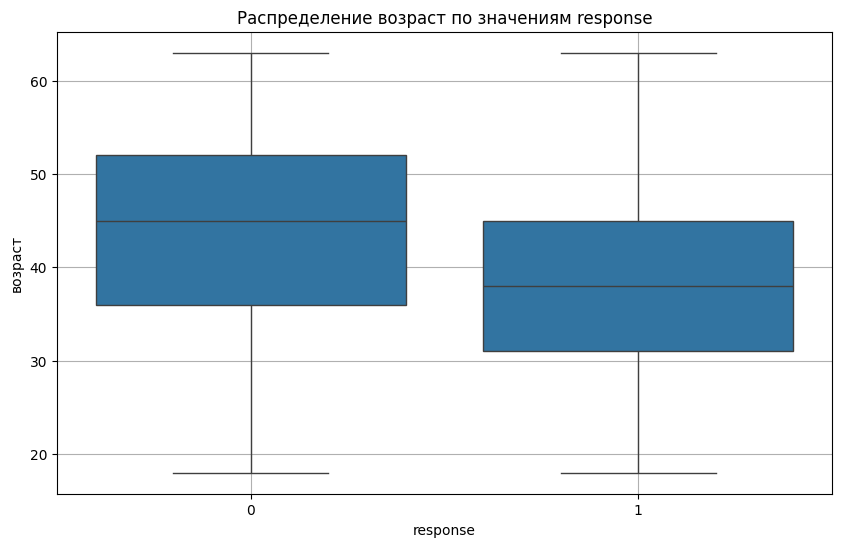

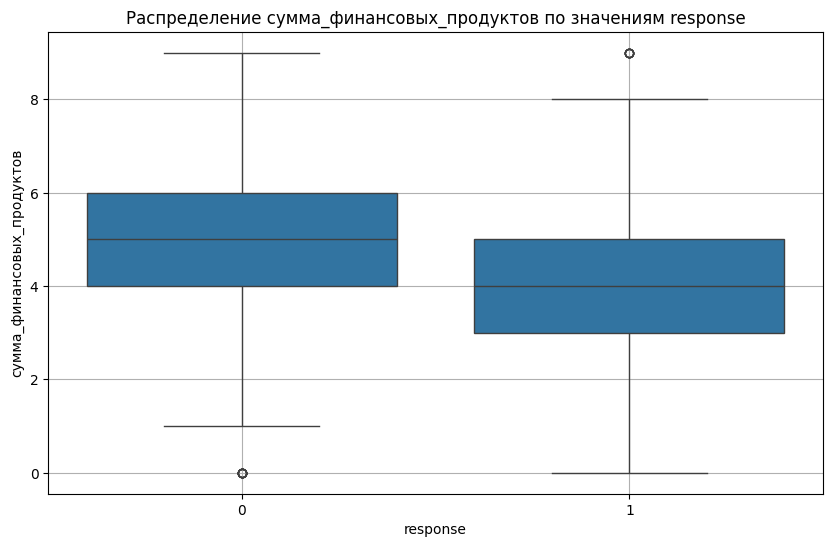

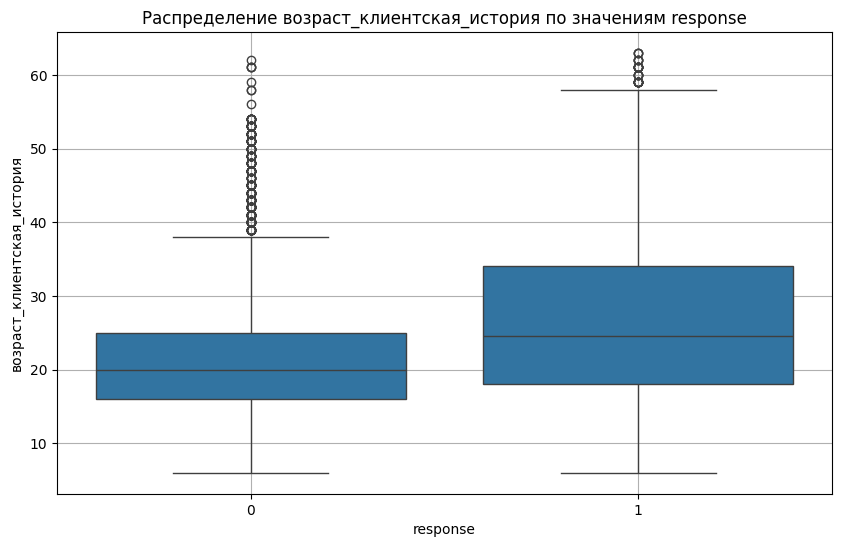

In [ ]:
# Создаем графики распределения для каждого числового признака по значениям response
for feature in numerical:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='response', y=feature, data=df)
    plt.title(f'Распределение {feature} по значениям response')
    plt.xlabel('response')
    plt.ylabel(feature)
    plt.grid()
    plt.show()

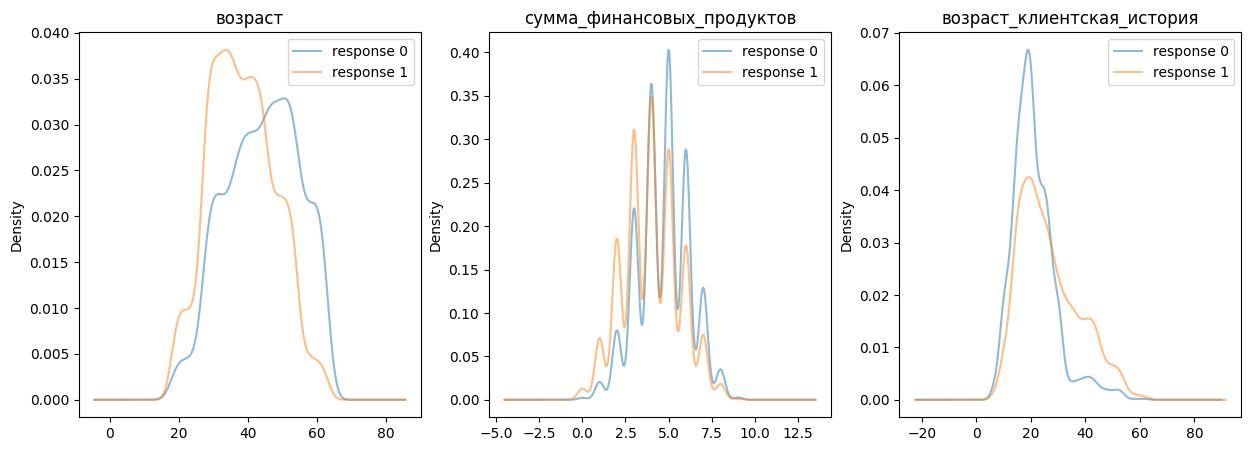

In [ ]:
# гистограммы и функции плотности для каждого признака в разрезе целевого признака
plt.figure(figsize=(15, 5))

for i, col in enumerate(numerical, 1):
    plt.subplot(1, 3, i)
    for response, data in df.groupby('response'):
        data[col].plot(kind='kde', label=f'response {response}', alpha=0.5)
    plt.title(col)
    plt.legend()

plt.show()

In [ ]:
column = df.drop(['response'], axis=1).columns
len(column)

17

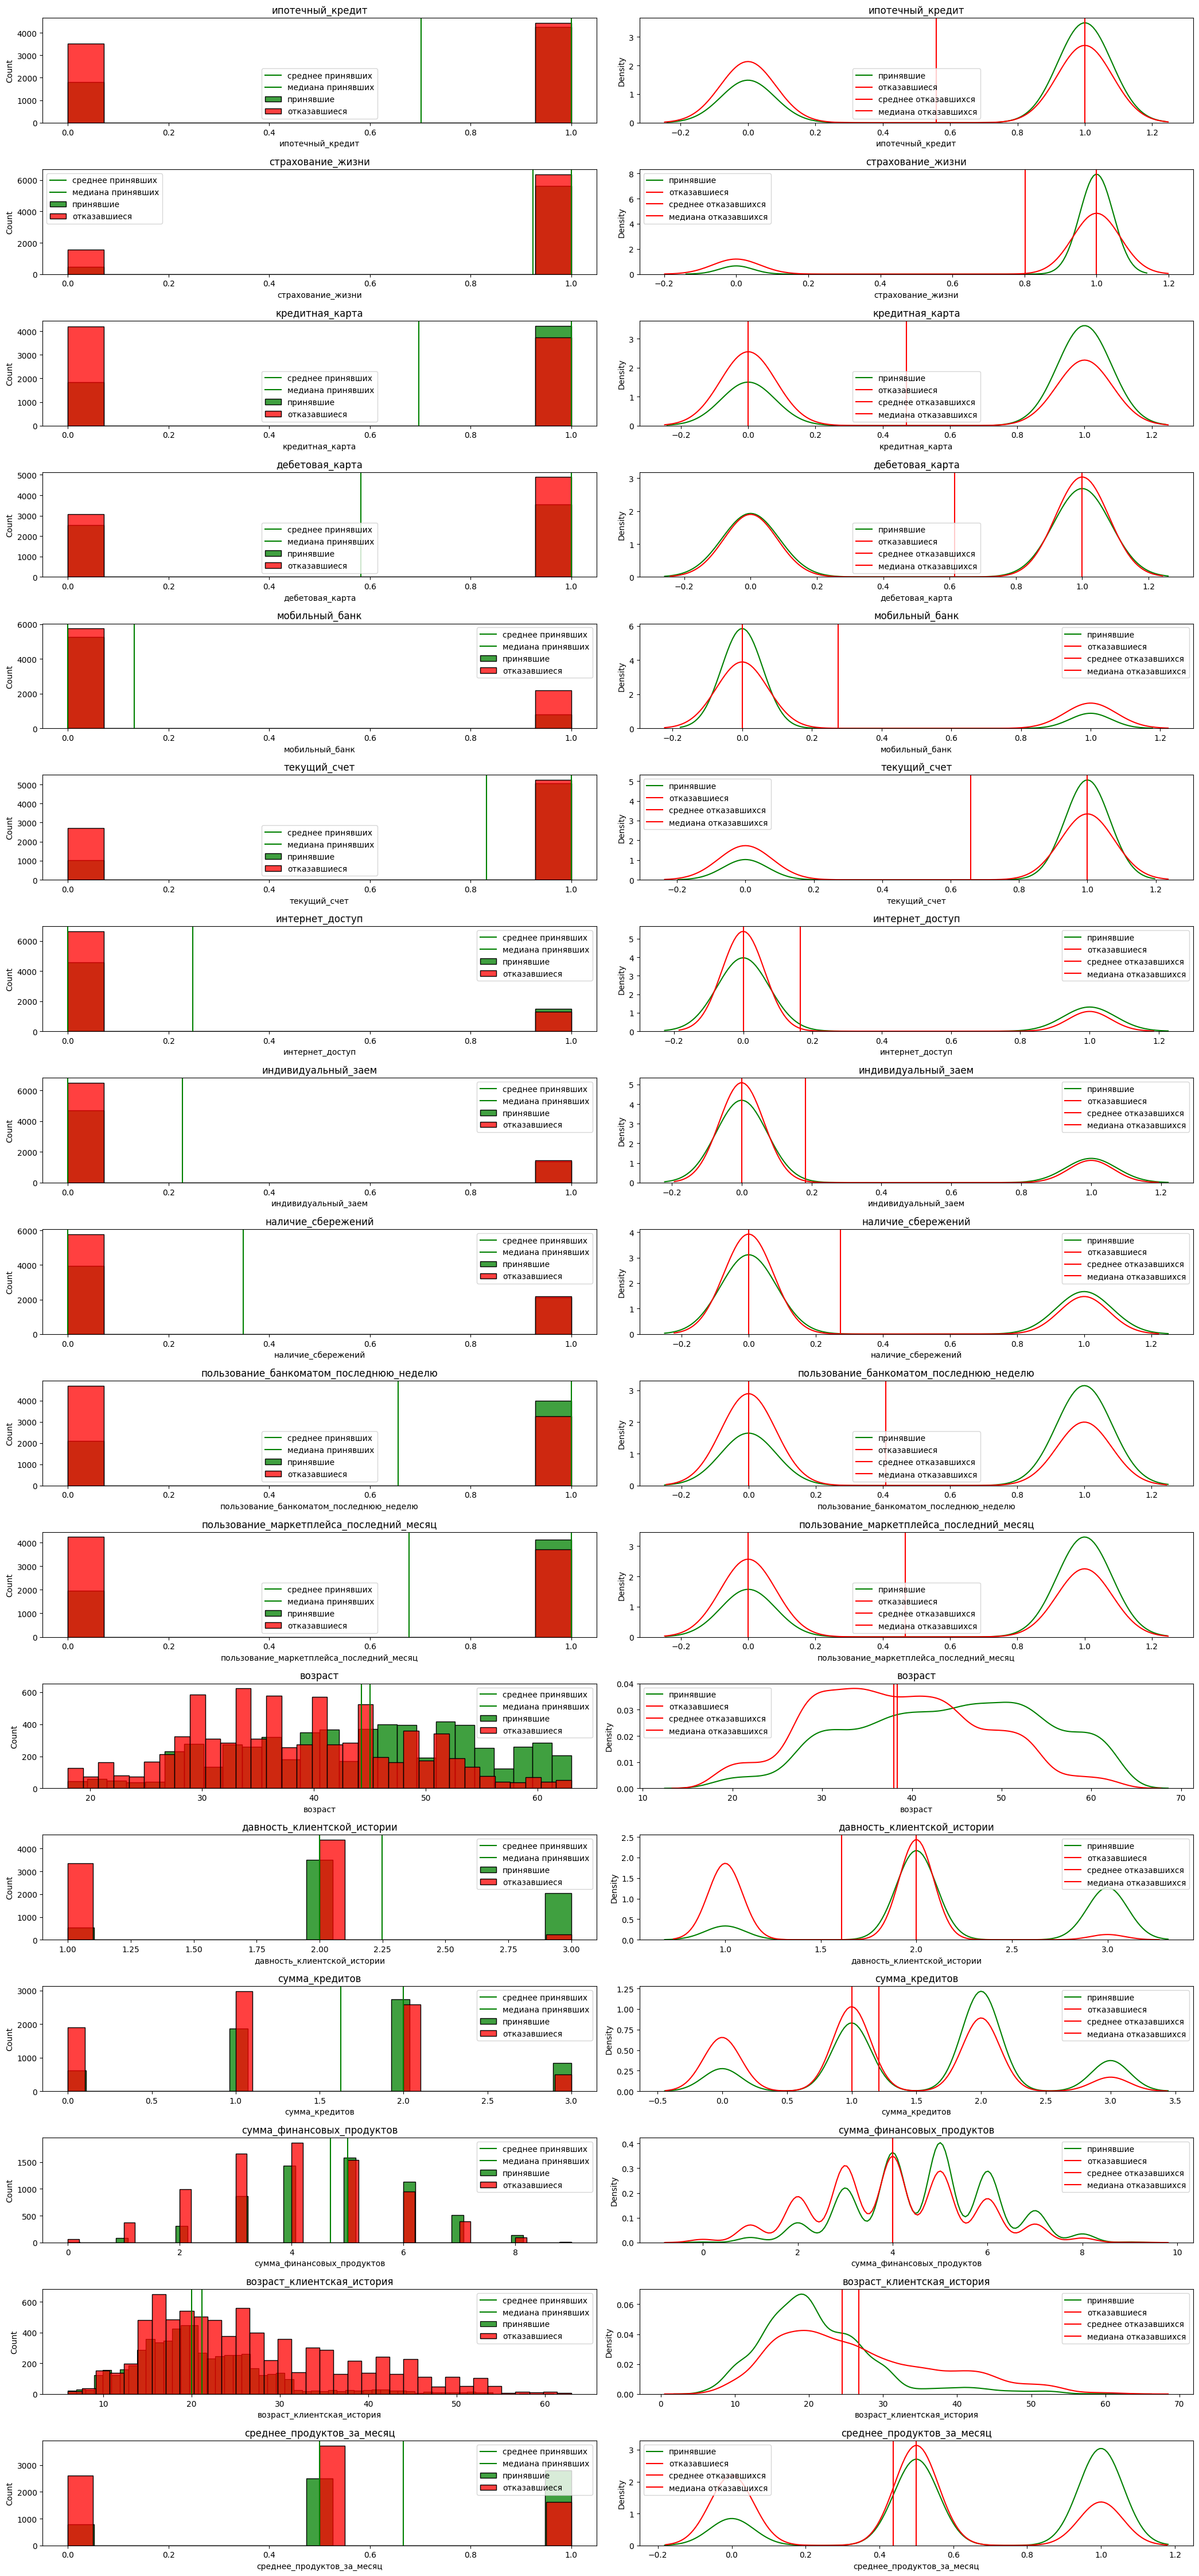

In [ ]:
# Построим графики для всех признаков
fig, ax = plt.subplots(17, 2, figsize=(21, 45))  # Увеличил высоту

for i, y in enumerate(column):
    plt.subplot(17, 2, 2*i+1)
    mean_0 = df[df.response == 0][y].mean()
    median_0 = df[df.response == 0][y].median()

    ax = sns.histplot(data=df[df.response == 0],
                      x=y,
                      color='green',
                      label='принявшие')
    ax = sns.histplot(data=df[df.response == 1],
                      x=y,
                      color='red',
                      label='отказавшиеся')
    ax.axvline(mean_0, color='green', label='среднее принявших')
    ax.axvline(median_0, color='green', label='медиана принявших')
    plt.title(y, fontsize=12)  # Добавил заголовок для графика
    plt.legend()

    plt.subplot(17, 2, 2*i+2)
    mean_1 = df[df.response == 1][y].mean()
    median_1 = df[df.response == 1][y].median()

    ax = sns.kdeplot(data=df[df.response == 0],
                      x=y,
                      color='green',
                      label='принявшие')
    ax = sns.kdeplot(data=df[df.response == 1],
                      x=y,
                      color='red',
                      label='отказавшиеся')

    ax.axvline(mean_1, color='red', label='среднее отказавшихся')
    ax.axvline(median_1, color='red', label='медиана отказавшихся')

    plt.title(y, fontsize=12)  # Добавил заголовок для графика
    plt.legend()

plt.tight_layout()  # Убирает перекрытие подзаголовков и графиков
plt.show()

## Исследования возможных зависимостей целевого признака от объясняющих признаков

In [ ]:
# Построим матрицу корреляций
corr = df.corr()
sns.heatmap(corr, annot=True)

# Анализ распределения числовых признаков
sns.pairplot(df, hue='response')

Output hidden; open in https://colab.research.google.com to view.

## Составление портретов клиентов платежной системы в разрезе целевого признака

In [ ]:
# Портрет клиентов с response = 0
df_response_0 = df[df['response'] == 0]
mean_values_response_0 = df_response_0.mean()

# Портрет клиентов с response = 1
df_response_1 = df[df['response'] == 1]
mean_values_response_1 = df_response_1.mean()

# Сравнение портретов
print("Портрет клиентов с response = 0:")
print(mean_values_response_0)
print('*'*21)
print("Портрет клиентов с response = 1:")
print(mean_values_response_1)

Портрет клиентов с response = 0:
ипотечный_кредит                             0.701463
страхование_жизни                            0.923886
кредитная_карта                              0.697024
дебетовая_карта                              0.581785
мобильный_банк                               0.131514
текущий_счет                                 0.831333
интернет_доступ                              0.247904
индивидуальный_заем                          0.227684
наличие_сбережений                           0.348841
пользование_банкоматом_последнюю_неделю      0.656091
пользование_маркетплейса_последний_месяц     0.677297
возраст                                     44.224560
давность_клиентской_истории                  2.248233
response                                     0.000000
сумма_кредитов                               1.626171
сумма_финансовых_продуктов                   4.691435
возраст_клиентская_история                  21.204861
среднее_продуктов_за_месяц                   0.66

Клиенты, склонные откликнуться на предложение о новой карте, являются более молодыми (в среднем 38 лет), менее зависимыми от кредитных карт, но ценящими безопасность и стабильность через страхование жизни и ипотеку. Они активно пользуются дебетовыми картами и имеют расчетные счета, что делает их подход к финансам более осторожным и взвешенным. У них невысокие сбережения, поэтому новое предложение может представлять заинтересованность в улучшении финансовых условий.

# 4. Составление и проверка гипотезы о наличие/отсутствии различий по признакам портрета клиента.

H0 - статистически значимых различий между клиентами принявшим и отказавшимися принять предложение банка нет.

H1 - статистически значимые различия между клиентами принявшим и отказавшимися принять предложение банка есть.

alpha = 0.05

In [ ]:
# проверка нормальности распределений признаков

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()


for feature in numeric_features:
    stat, p = stats.shapiro(df[feature])
    alpha = 0.05
    if p > alpha:
        print(f'Признак: {feature} имеет нормальное распределение (p-value={p})')
    else:
        print(f'Признак: {feature} не имеет нормального распределения (p-value={p})')

Признак: ипотечный_кредит не имеет нормального распределения (p-value=5.47851858848519e-100)
Признак: страхование_жизни не имеет нормального распределения (p-value=1.7079986223296166e-110)
Признак: кредитная_карта не имеет нормального распределения (p-value=4.983166583631729e-99)
Признак: дебетовая_карта не имеет нормального распределения (p-value=1.4583418475896197e-99)
Признак: мобильный_банк не имеет нормального распределения (p-value=2.0550041306992793e-106)
Признак: текущий_счет не имеет нормального распределения (p-value=8.171316636086004e-104)
Признак: интернет_доступ не имеет нормального распределения (p-value=4.508466378480313e-107)
Признак: индивидуальный_заем не имеет нормального распределения (p-value=4.9857504210864586e-107)
Признак: наличие_сбережений не имеет нормального распределения (p-value=3.2208012808965703e-102)
Признак: пользование_банкоматом_последнюю_неделю не имеет нормального распределения (p-value=1.3628925362138341e-98)
Признак: пользование_маркетплейса_посл

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14036.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# Создадим два датафрейма - df_response_0 и df_response_1, содержащие строки с response=0 и response=1 соответственно.

df_response_0 = df[df['response'] == 0]
df_response_1 = df[df['response'] == 1]

In [ ]:
# посчитаем средние значения признаков для каждой из групп.

mean_values_response_0 = df_response_0.mean()
mean_values_response_1 = df_response_1.mean()

In [ ]:
# проверим гипотезу о равенстве медианных значений признаков двух групп.
# применяем mannwhitneyu дле признаков с ненормальным распределением

from scipy.stats import ttest_ind

alpha = 0.05  # задаем уровень значимости

for feature in df.columns:
    t_stat, p_value = mannwhitneyu(df_response_0[feature], df_response_1[feature])
    if p_value < alpha:
        print(f"Отвергаем нулевую гипотезу для признака {feature}: медианные значения различаются")
    else:
        print(f"Не отвергаем нулевую гипотезу для признака {feature}: медианные значения не различаются")

Отвергаем нулевую гипотезу для признака ипотечный_кредит: средние значения различаются
Отвергаем нулевую гипотезу для признака страхование_жизни: средние значения различаются
Отвергаем нулевую гипотезу для признака кредитная_карта: средние значения различаются
Отвергаем нулевую гипотезу для признака дебетовая_карта: средние значения различаются
Отвергаем нулевую гипотезу для признака мобильный_банк: средние значения различаются
Отвергаем нулевую гипотезу для признака текущий_счет: средние значения различаются
Отвергаем нулевую гипотезу для признака интернет_доступ: средние значения различаются
Отвергаем нулевую гипотезу для признака индивидуальный_заем: средние значения различаются
Отвергаем нулевую гипотезу для признака наличие_сбережений: средние значения различаются
Отвергаем нулевую гипотезу для признака пользование_банкоматом_последнюю_неделю: средние значения различаются
Отвергаем нулевую гипотезу для признака пользование_маркетплейса_последний_месяц: средние значения различаются


На уровне значимости alpha = 0.05

Отвергаем H0, что статистически значимых различий между клиентами принявшим и отказавшимися принять предложение банка нет.

Принимаем H1, что статистически значимые различия между клиентами принявшим и отказавшимися принять предложение банка есть.

# 5. Построние классификационных моделей.

In [ ]:

X = df.drop(['response'], axis=1)
y = df['response']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## закодируем и нормализуем признаки для обучения модели

In [ ]:
# кодируем и нормализуем признаки
X_train_enc, X_test_enc = encode_category_feature(X_train, X_test, categorical)
X_train_norm, X_test_norm = standard(X_train_enc, X_test_enc, numerical)

In [ ]:
# Инициализация и обучение модели
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train_norm, y_train)

RandomForestClassifier(class_weight='balanced')

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test_norm)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Accuracy: 0.6136039886039886
Precision: 0.6615946439440049
Recall: 0.6726485148514851
F1 score: 0.6670757901196686


## Обучим три модели классификации и подберем пороговые значения

In [ ]:
# Использование функции
df_result = modeling(RandomForestClassifier(class_weight='balanced'),X_train_norm, y_train, X_test_norm, y_test)
df_result

,model_name,roc_auc_train,roc_auc_test,roc_auc_cv,accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,f1_cv,tn,fp,fn,tp
0,RandomForestClassifier,0.974786,0.694266,0.697181,0.889384,0.612179,0.86208,0.678837,0.897929,0.668291,0.667641,622,570,519,1097


In [ ]:
# Использование функции
new_data = modeling(XGBClassifier(),X_train_norm, y_train, X_test_norm, y_test)

new_row = pd.DataFrame(new_data)

# Добавляем данные
df_result = pd.concat([df_result, new_row], ignore_index=True)
df_result

,model_name,roc_auc_train,roc_auc_test,roc_auc_cv,accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,f1_cv,tn,fp,fn,tp
0,RandomForestClassifier,0.974786,0.694266,0.697181,0.889384,0.612179,0.862080,0.678837,0.897929,0.668291,0.667641,622,570,519,1097
1,XGBClassifier,0.890424,0.799318,0.788166,0.788208,0.700855,0.830993,0.771658,0.815802,0.748050,0.734790,721,471,369,1247


In [ ]:
# Использование функции
new_data = modeling(LGBMClassifier(),X_train_norm, y_train, X_test_norm, y_test)

new_row = pd.DataFrame(new_data)

# Добавляем данные
df_result = pd.concat([df_result, new_row], ignore_index=True)
df_result

[LightGBM] [Info] Number of positive: 6337, number of negative: 4891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 11228, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564393 -> initscore=0.259009
[LightGBM] [Info] Start training from score 0.259009
[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:B

,model_name,roc_auc_train,roc_auc_test,roc_auc_cv,accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,f1_cv,tn,fp,fn,tp
0,RandomForestClassifier,0.974786,0.694266,0.697181,0.889384,0.612179,0.862080,0.678837,0.897929,0.668291,0.667641,622,570,519,1097
1,XGBClassifier,0.890424,0.799318,0.788166,0.788208,0.700855,0.830993,0.771658,0.815802,0.748050,0.734790,721,471,369,1247
2,LGBMClassifier,0.862806,0.820947,0.808819,0.765942,0.730769,0.808900,0.792698,0.795963,0.772152,0.752373,771,421,335,1281


## Определим и удалим признаки с низкой корреляцией и нулевой значимостью для модели

In [ ]:
df_small = high_corr(df)

[]


Определение важности признаков с помощью библиотеки SHAP и алгоритма XGBoost

In [ ]:
df_little = important(df_small)

Признаки с нулевой значимостью:
['страхование_жизни', 'дебетовая_карта', 'мобильный_банк', 'интернет_доступ', 'индивидуальный_заем', 'наличие_сбережений', 'пользование_маркетплейса_последний_месяц', 'сумма_кредитов', 'сумма_финансовых_продуктов', 'возраст_клиентская_история']


Для сравнения снова обучим те-же модели

In [ ]:
# Учитывая что все признаки числовые произведем условное разделение признаков по количеству значений в признаке
df_types = df_little.drop(['response'], axis=1)
numerical = [col for col in df_types.columns if len(df_types[col].value_counts()) > 5]
categorical = [col for col in df_types.columns if len(df_types[col].value_counts()) <= 5]
print(numerical)
print(categorical)

['возраст']
['ипотечный_кредит', 'кредитная_карта', 'текущий_счет', 'пользование_банкоматом_последнюю_неделю', 'давность_клиентской_истории', 'среднее_продуктов_за_месяц']


In [ ]:

X_l = df_little.drop(['response'], axis=1)
y_l = df_little['response']

# Разделение данных на обучающую и тестовую выборки
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size=0.2, random_state=42)

In [ ]:
# кодируем и нормализуем признаки
X_train_enc_l, X_test_enc_l = encode_category_feature(X_train_l, X_test_l, categorical)
X_train_norm_l, X_test_norm_l = standard(X_train_enc_l, X_test_enc_l, numerical)

In [ ]:
# Использование функции
new_data = modeling(RandomForestClassifier(class_weight='balanced'),X_train_norm_l, y_train_l, X_test_norm_l, y_test_l)

new_row = pd.DataFrame(new_data)

# Добавляем данные
df_result = pd.concat([df_result, new_row], ignore_index=True)
df_result

,model_name,roc_auc_train,roc_auc_test,roc_auc_cv,accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,f1_cv,tn,fp,fn,tp
0,RandomForestClassifier,0.974786,0.694266,0.697181,0.889384,0.612179,0.862080,0.678837,0.897929,0.668291,0.667641,622,570,519,1097
1,XGBClassifier,0.890424,0.799318,0.788166,0.788208,0.700855,0.830993,0.771658,0.815802,0.748050,0.734790,721,471,369,1247
2,LGBMClassifier,0.862806,0.820947,0.808819,0.765942,0.730769,0.808900,0.792698,0.795963,0.772152,0.752373,771,421,335,1281
3,RandomForestClassifier,0.874326,0.768011,0.758037,0.771910,0.683405,0.747357,0.689356,0.787169,0.714790,0.703607,805,387,502,1114


In [ ]:
# Использование функции
new_data = modeling(XGBClassifier(),X_train_norm_l, y_train_l, X_test_norm_l, y_test_l)

new_row = pd.DataFrame(new_data)

# Добавляем данные
df_result = pd.concat([df_result, new_row], ignore_index=True)
df_result

,model_name,roc_auc_train,roc_auc_test,roc_auc_cv,accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,f1_cv,tn,fp,fn,tp
0,RandomForestClassifier,0.974786,0.694266,0.697181,0.889384,0.612179,0.862080,0.678837,0.897929,0.668291,0.667641,622,570,519,1097
1,XGBClassifier,0.890424,0.799318,0.788166,0.788208,0.700855,0.830993,0.771658,0.815802,0.748050,0.734790,721,471,369,1247
2,LGBMClassifier,0.862806,0.820947,0.808819,0.765942,0.730769,0.808900,0.792698,0.795963,0.772152,0.752373,771,421,335,1281
3,RandomForestClassifier,0.874326,0.768011,0.758037,0.771910,0.683405,0.747357,0.689356,0.787169,0.714790,0.703607,805,387,502,1114
4,XGBClassifier,0.852792,0.803767,0.796077,0.760599,0.710114,0.808269,0.785891,0.792144,0.757305,0.751723,724,468,346,1270


In [ ]:
# Использование функции
new_data = modeling(LGBMClassifier(),X_train_norm_l, y_train_l, X_test_norm_l, y_test_l)

new_row = pd.DataFrame(new_data)

# Добавляем данные
df_result = pd.concat([df_result, new_row], ignore_index=True)
df_result

[LightGBM] [Info] Number of positive: 6337, number of negative: 4891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 11228, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564393 -> initscore=0.259009
[LightGBM] [Info] Start training from score 0.259009
[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:Boost

,model_name,roc_auc_train,roc_auc_test,roc_auc_cv,accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,f1_cv,tn,fp,fn,tp
0,RandomForestClassifier,0.974786,0.694266,0.697181,0.889384,0.612179,0.862080,0.678837,0.897929,0.668291,0.667641,622,570,519,1097
1,XGBClassifier,0.890424,0.799318,0.788166,0.788208,0.700855,0.830993,0.771658,0.815802,0.748050,0.734790,721,471,369,1247
2,LGBMClassifier,0.862806,0.820947,0.808819,0.765942,0.730769,0.808900,0.792698,0.795963,0.772152,0.752373,771,421,335,1281
3,RandomForestClassifier,0.874326,0.768011,0.758037,0.771910,0.683405,0.747357,0.689356,0.787169,0.714790,0.703607,805,387,502,1114
4,XGBClassifier,0.852792,0.803767,0.796077,0.760599,0.710114,0.808269,0.785891,0.792144,0.757305,0.751723,724,468,346,1270
5,LGBMClassifier,0.842633,0.816134,0.808747,0.750980,0.727208,0.805586,0.806931,0.785022,0.772970,0.761850,738,454,312,1304


## Выбор лучшей модели и подбор гиперпараметров.

Применяем библиотеку optuna

In [ ]:
# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-11-06 14:34:42,134] A new study created in memory with name: no-name-30650700-a7a3-4e94-bf04-46809a366a99
<ipython-input-166-eeff5165c535>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:34:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:34:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:34:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label

[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info] Start training from score 0.258839
[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info] Start training from score 0.258839
[LightGBM] [Info] Number of 

[I 2024-11-06 14:34:47,046] Trial 1 finished with value: 0.816894015054832 and parameters: {'classifier': 'LGBM', 'n_estimators': 184, 'learning_rate': 0.00697643309798478}. Best is trial 1 with value: 0.816894015054832.
<ipython-input-166-eeff5165c535>:192: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)
[I 2024-11-06 14:38:39,538] Trial 2 finished with value: 0.7826084912337723 and parameters: {'classifier': 'CatBoost', 'n_estimators': 140, 'learning_rate': 0.28242659883135934, 'depth': 15}. Best is trial 1 with value: 0.816894015054832.
<ipython-input-166-eeff5165c535>:187: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info] Start training from score 0.258839
[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info] Start training from score 0.258839
[LightGBM] [Info] Number of 

[I 2024-11-06 14:38:40,207] Trial 3 finished with value: 0.8168853949772006 and parameters: {'classifier': 'LGBM', 'n_estimators': 74, 'learning_rate': 0.04091024888162872}. Best is trial 1 with value: 0.816894015054832.


[LightGBM] [Info] Number of positive: 5070, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564399 -> initscore=0.259036
[LightGBM] [Info] Start training from score 0.259036


<ipython-input-166-eeff5165c535>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:38:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:38:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:38:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core

[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info] Start training from score 0.258839
[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info] Start training from score 0.258839
[LightGBM] [Info] Number of 

[I 2024-11-06 14:38:43,135] Trial 6 finished with value: 0.7854193656095876 and parameters: {'classifier': 'LGBM', 'n_estimators': 141, 'learning_rate': 0.3606995515490129}. Best is trial 1 with value: 0.816894015054832.


[LightGBM] [Info] Number of positive: 5070, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564399 -> initscore=0.259036
[LightGBM] [Info] Start training from score 0.259036


<ipython-input-166-eeff5165c535>:192: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)
[I 2024-11-06 14:39:06,559] Trial 7 finished with value: 0.8147552381154904 and parameters: {'classifier': 'CatBoost', 'n_estimators': 123, 'learning_rate': 0.054000871437156386, 'depth': 13}. Best is trial 1 with value: 0.816894015054832.
<ipython-input-166-eeff5165c535>:187: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)


[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info] Start training from score 0.258839
[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info]

[I 2024-11-06 14:39:08,268] Trial 8 finished with value: 0.8169199815697873 and parameters: {'classifier': 'LGBM', 'n_estimators': 146, 'learning_rate': 0.02002626407440289}. Best is trial 8 with value: 0.8169199815697873.
<ipython-input-166-eeff5165c535>:187: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1)


[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info] Start training from score 0.258839
[LightGBM] [Info] Number of positive: 5069, number of negative: 3913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564351 -> initscore=0.258839
[LightGBM] [Info]

[I 2024-11-06 14:39:09,086] Trial 9 finished with value: 0.8147570270833766 and parameters: {'classifier': 'LGBM', 'n_estimators': 84, 'learning_rate': 0.005677849026441096}. Best is trial 8 with value: 0.8169199815697873.


In [ ]:
# Вывод результатов
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.8169199815697873
  Params:
    classifier: LGBM
    n_estimators: 146
    learning_rate: 0.02002626407440289


In [ ]:
# Обучаем лучшую модель
best_classifier_name = trial.params['classifier']
best_params = {key: value for key, value in trial.params.items() if key != 'classifier'}

In [ ]:
# Создаём лучшую модель
if best_classifier_name == 'RandomForest':
    best_model = RandomForestClassifier(**best_params)
elif best_classifier_name == 'LGBM':
    best_model = LGBMClassifier(**best_params)
elif best_classifier_name == 'CatBoost':
    best_model = CatBoostClassifier(**best_params, verbose=0)
else:  # XGBoost
    best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')

In [ ]:
best_model

LGBMClassifier(learning_rate=0.02002626407440289, n_estimators=146)

[LightGBM] [Info] Number of positive: 6337, number of negative: 4891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 11228, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564393 -> initscore=0.259009
[LightGBM] [Info] Start training from score 0.259009


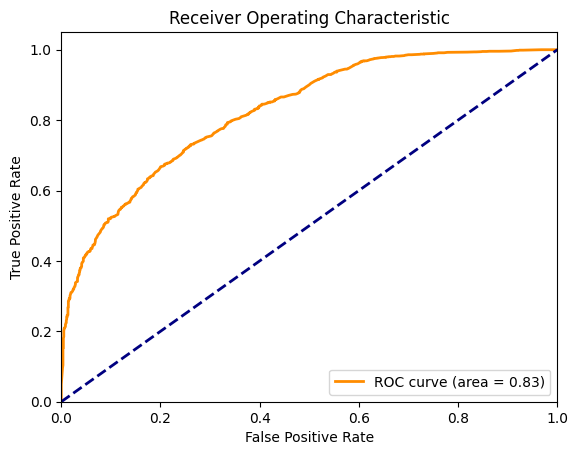

In [ ]:
# Обучение финальной модели
best_model.fit(X_train_norm_l, y_train_l)

# Прогнозирование вероятностей для ROC-кривой
y_probs = best_model.predict_proba(X_test_norm_l)[:, 1]

# Расчет ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Визуализация
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# метрики обученых, в ходе эксперементов моделей
print('метрики обученых, в ходе эксперементов моделей:')
df_result

метрики обученых, в ходе эксперементов моделей:


,model_name,roc_auc_train,roc_auc_test,roc_auc_cv,accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test,f1_cv,tn,fp,fn,tp
0,RandomForestClassifier,0.974786,0.694266,0.697181,0.889384,0.612179,0.862080,0.678837,0.897929,0.668291,0.667641,622,570,519,1097
1,XGBClassifier,0.890424,0.799318,0.788166,0.788208,0.700855,0.830993,0.771658,0.815802,0.748050,0.734790,721,471,369,1247
2,LGBMClassifier,0.862806,0.820947,0.808819,0.765942,0.730769,0.808900,0.792698,0.795963,0.772152,0.752373,771,421,335,1281
3,RandomForestClassifier,0.874326,0.768011,0.758037,0.771910,0.683405,0.747357,0.689356,0.787169,0.714790,0.703607,805,387,502,1114
4,XGBClassifier,0.852792,0.803767,0.796077,0.760599,0.710114,0.808269,0.785891,0.792144,0.757305,0.751723,724,468,346,1270
5,LGBMClassifier,0.842633,0.816134,0.808747,0.750980,0.727208,0.805586,0.806931,0.785022,0.772970,0.761850,738,454,312,1304


# Выводы:

### Описание типичных клиентов

#### Клиенты с response = 0 (не принявшие предложение банка)
- **Ипотечный кредит:** Высокий уровень (70.15%), что может говорить о заинтересованности в недвижимости.
- **Страхование жизни:** Очень высокий показатель (92.39%), возможно, клиенты ценят безопасность и стабильность.
- **Кредитные карты:** Уровень 69.70% указывает на частое пользование карточками, но комфорт в кредитах не самый высокий.
- **Дебетовые карты:** Немного ниже (58.18%), показывая умеренную зависимость от расчетов.
- **Мобильный банк:** Низкий уровень (13.15%), что может говорить о недостаточной вовлеченности в цифровые услуги.
- **Текущий счет:** Высокий уровень (83.13%), что говорит о наличии активных средств.
- **Возраст:** Средний возраст 44 года, возможно, более зрелая аудитория.
- **Сумма кредитов:** Наличие 1.63, что может сигнализировать о том, что у клиентов уже есть некоторые обязательства.
- **Среднее количество продуктов за месяц:** 0.67, предполагает умеренную активность в банковских продуктах.

#### Клиенты с response = 1 (принявшие предложение банка)
- **Ипотечный кредит:** Низкий уровень (55.83%), что может указывать на более осторожное планирование.
- **Страхование жизни:** Высокий, но ниже, чем у первой группы (80.16%), продолжают ценить безопасность, но возможно, ищут лучшие условия.
- **Кредитные карты:** Значительно ниже (47.00%), что может означать, что эти клиенты менее склонны к безрассудным кредитам.
- **Дебетовые карты:** Более высокое использование (61.50%), возможно, предпочитают контролировать свои расходы.
- **Мобильный банк:** Умеренно низкий уровень (27.57%), указывающий на растущей интерес к цифровым услугам.
- **Текущий счет:** Уровень 65.86%, что также сигнализирует о наличии активных средств, но не таких высоких, как в предыдущей группе.
- **Возраст:** Средний возраст 38 лет, вероятно, более молодая аудитория.
- **Сумма кредитов:** 1.21, нижний уровень, чем у группы с response=0, может осознанный подход к новым кредитным обязательствам.
- **Среднее количество продуктов за месяц:** 0.44, предполагает большую осторожность в использовании банковских продуктов.

Клиенты, склонные откликнуться на предложение о новой карте:

 являются более молодыми (в среднем 38 лет),

менее зависимыми от кредитных карт,

но ценящими безопасность и стабильность через страхование жизни и ипотеку.

Они активно пользуются дебетовыми картами и имеют расчетные счета,

что делает их подход к финансам более осторожным и взвешенным.

У них невысокие сбережения, поэтому новое предложение может представлять заинтересованность в улучшении финансовых условий.